### Create pyspark session

In [37]:
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-2.4.7'
# spark_version = 'spark-2.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done


In [38]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("YelpReview").getOrCreate()

In [39]:
from pyspark.sql.functions import col, udf,length, size
from pyspark.sql.types import StringType

### pyspark - Data cleaning

In [40]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://usc-bootcamp-yelpreview-text-analysis.s3.us-east-2.amazonaws.com/reviews.csv"
spark.sparkContext.addFile(url)
raw_df = spark.read.csv(SparkFiles.get("reviews.csv"), sep=",", header=True)

# Show DataFrame
raw_df.show()

+--------------------+-------------+------------+
|             reviews|       rating|review_count|
+--------------------+-------------+------------+
|Panda Express was...|5 star rating|          63|
|The dude and I ca...|5 star rating|          63|
|I ordered 5 total...|1 star rating|          63|
|I always order Pa...|3 star rating|          63|
|Decided to try Pa...|5 star rating|          63|
|I've never had a ...|4 star rating|          63|
|The family meal d...|1 star rating|          63|
|Quality has sever...|2 star rating|          63|
|Paid for a bowl a...|1 star rating|          63|
|Order a bowl with...|1 star rating|          63|
|Went through the ...|1 star rating|          63|
|When I think of p...|2 star rating|          63|
|Horrible is a und...|1 star rating|          63|
|Yes the drive thr...|2 star rating|          63|
|Okay..so Panda is...|4 star rating|          63|
|Going through Dri...|2 star rating|          63|
|My entrees were a...|2 star rating|          63|


In [118]:
# new column function - reduce dimension of rating column into 3 categories
def rating_category(rating:str)->str:
  """create new column for label
  """
  if rating in ["1 star rating","2 star rating"]:
      return "negative"
  elif rating in [ "3 star rating"]:
      return "neutral"
  else: 
      return "positive"

assert rating_category("1 star rating")=="negative"


In [119]:
# Store a user defined function
convert_rating = udf(rating_category, StringType())
convert_rating

<function __main__.rating_category>

In [120]:
# add new column
selected_df = raw_df.withColumn("output_label", convert_rating(col("rating")))
selected_df = selected_df.withColumn("length", length(selected_df["reviews"]))
selected_df.show()

+--------------------+-------------+------------+------------+------+
|             reviews|       rating|review_count|output_label|length|
+--------------------+-------------+------------+------------+------+
|Panda Express was...|5 star rating|          63|    positive|   334|
|The dude and I ca...|5 star rating|          63|    positive|   770|
|I ordered 5 total...|1 star rating|          63|    negative|   151|
|I always order Pa...|3 star rating|          63|     neutral|   628|
|Decided to try Pa...|5 star rating|          63|    positive|   261|
|I've never had a ...|4 star rating|          63|    positive|   640|
|The family meal d...|1 star rating|          63|    negative|   129|
|Quality has sever...|2 star rating|          63|    negative|   350|
|Paid for a bowl a...|1 star rating|          63|    negative|   158|
|Order a bowl with...|1 star rating|          63|    negative|   151|
|Went through the ...|1 star rating|          63|    negative|   675|
|When I think of p..

### pyspark - Feature Transformation

In [121]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer


In [122]:
# create token and remove stop words in order to find out stopwords percentage
tokenizer = Tokenizer(inputCol="reviews", outputCol="token")
selected_df = tokenizer.transform(selected_df)
stop_word_remover = StopWordsRemover(inputCol="token", outputCol="filtered_token")
selected_df = stop_word_remover.transform(selected_df)
selected_df.show()

+--------------------+-------------+------------+------------+------+--------------------+--------------------+
|             reviews|       rating|review_count|output_label|length|               token|      filtered_token|
+--------------------+-------------+------------+------------+------+--------------------+--------------------+
|Panda Express was...|5 star rating|          63|    positive|   334|[panda, express, ...|[panda, express, ...|
|The dude and I ca...|5 star rating|          63|    positive|   770|[the, dude, and, ...|[dude, came, pand...|
|I ordered 5 total...|1 star rating|          63|    negative|   151|[i, ordered, 5, t...|[ordered, 5, tota...|
|I always order Pa...|3 star rating|          63|     neutral|   628|[i, always, order...|[always, order, p...|
|Decided to try Pa...|5 star rating|          63|    positive|   261|[decided, to, try...|[decided, try, pa...|
|I've never had a ...|4 star rating|          63|    positive|   640|[i've, never, had...|[never, bad, e

In [123]:
selected_df = selected_df.withColumn("stopwords_count", size(selected_df["filtered_token"]))
selected_df = selected_df.withColumn("stopwords_percent", selected_df["stopwords_count"]/selected_df["length"])
selected_df.show()

+--------------------+-------------+------------+------------+------+--------------------+--------------------+---------------+-------------------+
|             reviews|       rating|review_count|output_label|length|               token|      filtered_token|stopwords_count|  stopwords_percent|
+--------------------+-------------+------------+------------+------+--------------------+--------------------+---------------+-------------------+
|Panda Express was...|5 star rating|          63|    positive|   334|[panda, express, ...|[panda, express, ...|             37|0.11077844311377245|
|The dude and I ca...|5 star rating|          63|    positive|   770|[the, dude, and, ...|[dude, came, pand...|             80| 0.1038961038961039|
|I ordered 5 total...|1 star rating|          63|    negative|   151|[i, ordered, 5, t...|[ordered, 5, tota...|             22| 0.1456953642384106|
|I always order Pa...|3 star rating|          63|     neutral|   628|[i, always, order...|[always, order, p...| 

In [124]:
# create all features to the dataset
label_encoder = StringIndexer(inputCol="output_label", outputCol="label")
hasher = HashingTF(inputCol="filtered_token", outputCol="hashed_token")
idf = IDF(inputCol="hashed_token", outputCol="idf_token")


In [125]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
vectorizer = VectorAssembler(inputCols = ["idf_token", "length","stopwords_percent"], outputCol = "features")


### pyspark - Create a Pipeline to Automate The Data Transformations

In [126]:
# Create a and run a data processing Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[label_encoder, hasher, idf, vectorizer])


In [127]:
# fit and transform data with pipeline
pipeline_model = pipeline.fit(selected_df)
cleaned_df = pipeline_model.transform(selected_df)
cleaned_df.show()

+--------------------+-------------+------------+------------+------+--------------------+--------------------+---------------+-------------------+-----+--------------------+--------------------+--------------------+
|             reviews|       rating|review_count|output_label|length|               token|      filtered_token|stopwords_count|  stopwords_percent|label|        hashed_token|           idf_token|            features|
+--------------------+-------------+------------+------------+------+--------------------+--------------------+---------------+-------------------+-----+--------------------+--------------------+--------------------+
|Panda Express was...|5 star rating|          63|    positive|   334|[panda, express, ...|[panda, express, ...|             37|0.11077844311377245|  1.0|(262144,[2711,610...|(262144,[2711,610...|(262146,[2711,610...|
|The dude and I ca...|5 star rating|          63|    positive|   770|[the, dude, and, ...|[dude, came, pand...|             80| 0.10

### pyspark - Create training and testing dataset

In [128]:
from pyspark.ml.classification import NaiveBayes

# Break data down into a training set and a testing set
training, testing = cleaned_df.randomSplit([0.7, 0.3], seed = 43)

### pyspark - Fit and predict NaiveBaye model

In [129]:
# Create a Naive Bayes model and fit training data
model = NaiveBayes()
predictor = model.fit(training)


In [130]:
# Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(5)

+--------------------+-------------+------------+------------+------+--------------------+--------------------+---------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|             reviews|       rating|review_count|output_label|length|               token|      filtered_token|stopwords_count|  stopwords_percent|label|        hashed_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+--------------------+-------------+------------+------------+------+--------------------+--------------------+---------------+-------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|"""I never want t...|2 star rating|          29|    negative|  1410|["""i, never, wan...|["""i, never, wan...|            141|                0.1|  0.0|(262144,[14,4200,...|(262144,[14,4200

### pyspark - Results

In [131]:
# Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting reviews was: %f" % acc)

Accuracy of model at predicting reviews was: 0.751259


In [132]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Create (prediction, label) pairs
predictionAndLabel = test_results.select("prediction", "label").rdd



In [60]:
# Generate confusion matrix
#select only prediction and label columns

metrics = MulticlassMetrics(predictionAndLabel.map(tuple))
print(metrics.confusionMatrix().toArray())

[[3027.  110.   26.]
 [ 404. 1177.   12.]
 [ 380.  179.   20.]]


### sklearn - Neutral Networking

In [230]:
import pandas as pd
import numpy as np

In [231]:
reviews = pd.read_csv(url)
reviews = reviews.iloc[:,0:2]
reviews.head()

,reviews,rating
0,Panda Express was on point tonight! I ordered ...,5 star rating
1,The dude and I came to this Panda Express arou...,5 star rating
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating
3,I always order Panda Express from here and the...,3 star rating
4,"I've never had a bad experience here, I don't ...",4 star rating


### sklearn - Clean up data, Changing rating column

In [232]:
# use defined function above to re-create rating column
reviews["rating_reduced"] = reviews["rating"].apply(rating_category)
reviews.head()

,reviews,rating,rating_reduced
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive
1,The dude and I came to this Panda Express arou...,5 star rating,positive
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative
3,I always order Panda Express from here and the...,3 star rating,neutral
4,"I've never had a bad experience here, I don't ...",4 star rating,positive


### sklearn - Feature Engineer

In [233]:
# create word count, and character count
reviews["word_list"] = reviews["reviews"].apply(lambda x: x.split())
reviews["word_count"] = reviews["word_list"].apply(lambda x: len(x))
reviews["char_count"] = reviews["reviews"].apply(lambda x: len(x))
reviews.head()

,reviews,rating,rating_reduced,word_list,word_count,char_count
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,"[Panda, Express, was, on, point, tonight!, I, ...",63,334
1,The dude and I came to this Panda Express arou...,5 star rating,positive,"[The, dude, and, I, came, to, this, Panda, Exp...",149,770
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,"[I, ordered, 5, total, plates, ,, fried, rice,...",30,154
3,I always order Panda Express from here and the...,3 star rating,neutral,"[I, always, order, Panda, Express, from, here,...",122,634
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,"[I've, never, had, a, bad, experience, here,, ...",120,644


In [235]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [236]:
# remove stop words, and get stopwords percentage
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

reviews["stop_word_count"] = reviews["word_list"].apply(lambda x: len([word for word in x if word.lower() in stop_words]))
reviews["stop_word_percent"] = reviews["stop_word_count"]/reviews["word_count"]
reviews.head()

,reviews,rating,rating_reduced,word_list,word_count,char_count,stop_word_count,stop_word_percent
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,"[Panda, Express, was, on, point, tonight!, I, ...",63,334,28,0.444444
1,The dude and I came to this Panda Express arou...,5 star rating,positive,"[The, dude, and, I, came, to, this, Panda, Exp...",149,770,69,0.463087
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,"[I, ordered, 5, total, plates, ,, fried, rice,...",30,154,8,0.266667
3,I always order Panda Express from here and the...,3 star rating,neutral,"[I, always, order, Panda, Express, from, here,...",122,634,57,0.467213
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,"[I've, never, had, a, bad, experience, here,, ...",120,644,58,0.483333


### sklearn - Data Cleaning

In [237]:
# lower case all the reviews, and remove all the punctuations
reviews["lowercase_reviews"] = reviews["reviews"].apply(lambda x: " ".join(word.lower() for word in x.split()))
reviews["lowercase_reviews"] = reviews["lowercase_reviews"].str.replace('[^\w\s]',"")
reviews["lowercase_reviews_list"] = reviews["lowercase_reviews"].apply(lambda x: x.split())
reviews.head()

,reviews,rating,rating_reduced,word_list,word_count,char_count,stop_word_count,stop_word_percent,lowercase_reviews,lowercase_reviews_list
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,"[Panda, Express, was, on, point, tonight!, I, ...",63,334,28,0.444444,panda express was on point tonight i ordered t...,"[panda, express, was, on, point, tonight, i, o..."
1,The dude and I came to this Panda Express arou...,5 star rating,positive,"[The, dude, and, I, came, to, this, Panda, Exp...",149,770,69,0.463087,the dude and i came to this panda express arou...,"[the, dude, and, i, came, to, this, panda, exp..."
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,"[I, ordered, 5, total, plates, ,, fried, rice,...",30,154,8,0.266667,i ordered 5 total plates fried rice chow mai...,"[i, ordered, 5, total, plates, fried, rice, ch..."
3,I always order Panda Express from here and the...,3 star rating,neutral,"[I, always, order, Panda, Express, from, here,...",122,634,57,0.467213,i always order panda express from here and the...,"[i, always, order, panda, express, from, here,..."
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,"[I've, never, had, a, bad, experience, here,, ...",120,644,58,0.483333,ive never had a bad experience here i dont und...,"[ive, never, had, a, bad, experience, here, i,..."


In [238]:
# remove any words has length more than 10
def remove_length10_word(word_list):
  """remove any words have length more than 10
  """
  final_list =[]
  for word in word_list:
    if len(word)<10:
      final_list.append(word)
  
  return final_list

assert remove_length10_word(["qwertfdfrwed","dfd","ddd","dddddddddfdfdfddf"])==["dfd","ddd"]


In [246]:
# store new review as lowercase_reviews after remove length greater than 10 words and join together
reviews["lowercase_reviews"] = reviews["lowercase_reviews_list"].apply(lambda x: " ".join(remove_length10_word(x)))

0        panda express was on point tonight i ordered t...
1        the dude and i came to this panda express arou...
2        i ordered 5 total plates fried rice chow main ...
3        i always order panda express from here and the...
4        ive never had a bad here i dont why its only 2...
                               ...                        
19516    food was alright upset they dont have changing...
19517    i just had a party for 30 people and i was so ...
19518    these people said they were open at midnight a...
19519    its pandex chow mien kung pau and orange chick...
19520    this one star review is because they give you ...
Name: lowercase_reviews_list, Length: 19521, dtype: object

In [248]:
# look at average length of each word in each review
def average_word_length(word_list)->int:
    """calculate the average word length in each review
    """
    word_length = []
    for word in word_list.split(): 
        word_length.append(len(word))
    return np.mean(word_length)

assert average_word_length("tests are hard")==4


In [249]:
# calculate average word length
reviews["average_word_length"] = reviews["lowercase_reviews"].apply(average_word_length)
reviews.head()

,reviews,rating,rating_reduced,word_list,word_count,char_count,stop_word_count,stop_word_percent,lowercase_reviews,lowercase_reviews_list,average_word_length,clean_reviews
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,"[Panda, Express, was, on, point, tonight!, I, ...",63,334,28,0.444444,panda express was on point tonight i ordered t...,"[panda, express, was, on, point, tonight, i, o...",4.032258,panda express point tonight ordered mobile app...
1,The dude and I came to this Panda Express arou...,5 star rating,positive,"[The, dude, and, I, came, to, this, Panda, Exp...",149,770,69,0.463087,the dude and i came to this panda express arou...,"[the, dude, and, i, came, to, this, panda, exp...",3.952055,dude came panda express around end july 2020 h...
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,"[I, ordered, 5, total, plates, ,, fried, rice,...",30,154,8,0.266667,i ordered 5 total plates fried rice chow main ...,"[i, ordered, 5, total, plates, fried, rice, ch...",4.407407,ordered 5 total plates fried rice chow main do...
3,I always order Panda Express from here and the...,3 star rating,neutral,"[I, always, order, Panda, Express, from, here,...",122,634,57,0.467213,i always order panda express from here and the...,"[i, always, order, panda, express, from, here,...",4.008333,always order panda express problem ever place ...
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,"[I've, never, had, a, bad, experience, here,, ...",120,644,58,0.483333,ive never had a bad here i dont why its only 2...,"[ive, never, had, a, bad, experience, here, i,...",3.930435,ive never bad dont 212 stars reading reviews s...


In [241]:
# remove stop words
reviews["clean_reviews"] = reviews["lowercase_reviews"].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
reviews.head()

,reviews,rating,rating_reduced,word_list,word_count,char_count,stop_word_count,stop_word_percent,lowercase_reviews,lowercase_reviews_list,average_word_length,clean_reviews
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,"[Panda, Express, was, on, point, tonight!, I, ...",63,334,28,0.444444,panda express was on point tonight i ordered t...,"[panda, express, was, on, point, tonight, i, o...",4.126984,panda express point tonight ordered mobile app...
1,The dude and I came to this Panda Express arou...,5 star rating,positive,"[The, dude, and, I, came, to, this, Panda, Exp...",149,770,69,0.463087,the dude and i came to this panda express arou...,"[the, dude, and, i, came, to, this, panda, exp...",4.080537,dude came panda express around end july 2020 h...
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,"[I, ordered, 5, total, plates, ,, fried, rice,...",30,154,8,0.266667,i ordered 5 total plates fried rice chow main ...,"[i, ordered, 5, total, plates, fried, rice, ch...",4.407407,ordered 5 total plates fried rice chow main do...
3,I always order Panda Express from here and the...,3 star rating,neutral,"[I, always, order, Panda, Express, from, here,...",122,634,57,0.467213,i always order panda express from here and the...,"[i, always, order, panda, express, from, here,...",4.106557,always order panda express problem ever place ...
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,"[I've, never, had, a, bad, experience, here,, ...",120,644,58,0.483333,ive never had a bad here i dont why its only 2...,"[ive, never, had, a, bad, experience, here, i,...",4.208333,ive never bad dont 212 stars reading reviews s...


In [252]:
# get final dataset
final_dataset = reviews.iloc[:,[0,1,2,4,5,6,7,10,11]]
final_dataset.head()

,reviews,rating,rating_reduced,word_count,char_count,stop_word_count,stop_word_percent,average_word_length,clean_reviews
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,63,334,28,0.444444,4.032258,panda express point tonight ordered mobile app...
1,The dude and I came to this Panda Express arou...,5 star rating,positive,149,770,69,0.463087,3.952055,dude came panda express around end july 2020 h...
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,30,154,8,0.266667,4.407407,ordered 5 total plates fried rice chow main do...
3,I always order Panda Express from here and the...,3 star rating,neutral,122,634,57,0.467213,4.008333,always order panda express problem ever place ...
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,120,644,58,0.483333,3.930435,ive never bad dont 212 stars reading reviews s...


### EDA on final_dataset

[Text(0.5, 1.0, 'distribution of stopwords percentage in each review')]

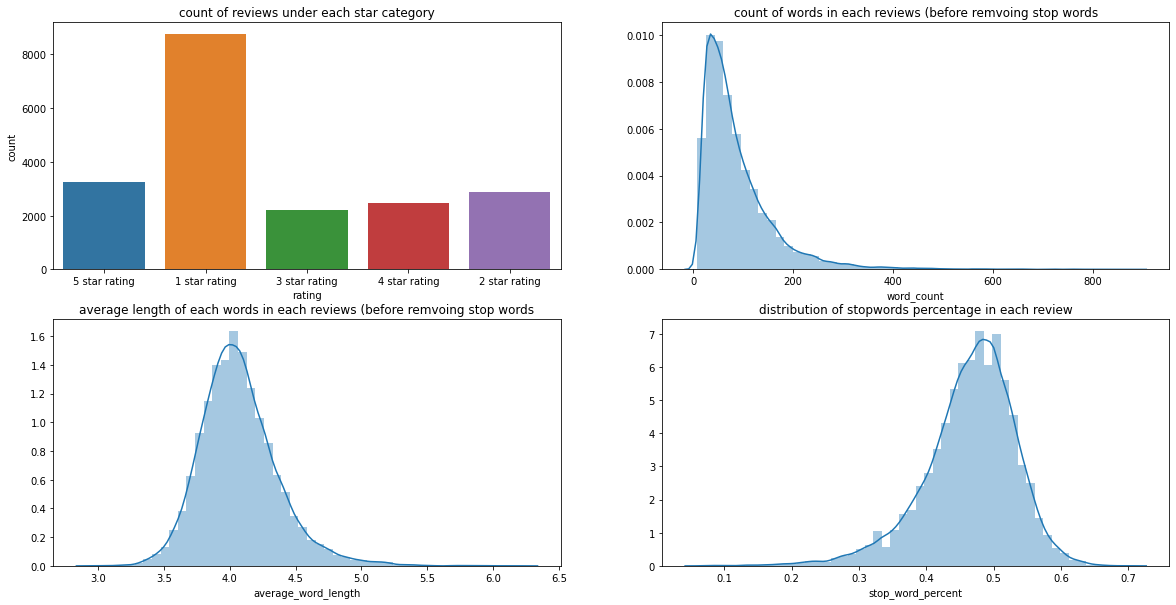

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2,figsize = (20,10))
sns.countplot(data = final_dataset, x="rating", ax=ax1).set(title = "count of reviews under each star category")
sns.distplot(final_dataset["word_count"], ax = ax2).set(title = "count of words in each reviews (before remvoing stop words")
sns.distplot(final_dataset["average_word_length"], ax = ax3).set(title = "average length of each words in each reviews (before remvoing stop words")
sns.distplot(final_dataset["stop_word_percent"], ax = ax4).set(title = "distribution of stopwords percentage in each review")




1.   We want to remove any word length greater than 10.
2.   Data has too many 1 star review, which might impact the classification. 
3.   We will look at the relationship between sentiment and those variables after we do sentiment analysis. 

---





### Create TF dataset

In [145]:
temp_dataset = final_dataset[["clean_reviews","rating_reduced"]]
temp_dataset.head()

,clean_reviews,rating_reduced
0,panda express point tonight ordered mobile app...,positive
1,dude came panda express around end july 2020 h...,positive
2,ordered 5 total plates fried rice chow main do...,negative
3,always order panda express problem ever place ...,neutral
4,ive never bad experience dont understand 212 s...,positive


In [146]:
# find out dataset size
data_size = len(temp_dataset["clean_reviews"])
data_size

19521

In [147]:
# one hot-encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
label_encoder.fit(temp_dataset["rating_reduced"])
encoded_y = label_encoder.transform(temp_dataset["rating_reduced"])
y_categorical = to_categorical(encoded_y)

y_categorical

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [148]:
# change dataset to tf dataset
import tensorflow as tf
tf_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(temp_dataset["clean_reviews"].values,tf.string), 
        tf.cast(y_categorical, tf.float64), 
    )
)



In [150]:
# example of tf dataset
for X_batch, y_batch in tf_dataset.batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label)
        print()

Review: panda express point tonight ordered mobile app picked order pick time ready time double checked order correct gave us extra utensils sauce food hot fresh superb customer service well best experience i ...
Label: [0. 0. 1.]

Review: dude came panda express around end july 2020 havent panda express use going inside lot panda drive thrus surprised stumbled upon one one usually go closed nightwe went drive thru quick process got pla ...
Label: [0. 0. 1.]



In [151]:
# character of each reviews
list_char = []
list_reviews = temp_dataset["clean_reviews"].apply(lambda x: x.split())
for review in list_reviews:
  char = []
  for word in review:
    char.append(len(word))
  list_char.append(sum(char))

pd.DataFrame(list_char).describe()

,0
count,19521.000000
mean,248.754828
std,206.006482
min,20.000000
25%,116.000000
50%,190.000000
75%,313.000000
max,2645.000000


In [152]:
# we will choose mean + one std as number of characters we want to look
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 500)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [153]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 79), dtype=string, numpy=
 array([[b'panda', b'express', b'point', b'tonight', b'ordered',
         b'mobile', b'app', b'picked', b'order', b'pick', b'time',
         b'ready', b'time', b'double', b'checked', b'order', b'correct',
         b'gave', b'us', b'extra', b'utensils', b'sauce', b'food', b'hot',
         b'fresh', b'superb', b'customer', b'service', b'well', b'best',
         b'experience', b'ive', b'panda', b'express', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>'],
        [b'dude', b'c

In [154]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in tf_dataset.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [155]:
# number of vocab
len(vocabulary)

26879

In [156]:
# vocab_size can be a parameter to be tunned
vocab_size = 15000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]


In [157]:
# example of relevant or irrentlant word in numbers
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"I like orange chicken patchouli".split():
    print(word_to_id.get(word) or vocab_size)

15000
9
20
3
15000


In [158]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)


### Create training and testing tf_dataset

In [160]:
# create train and test size
train_size = int(.7*data_size)
test_size = int(.3*data_size)

In [163]:
# create train and test, and we take 32 reviews per batch
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = tf_dataset.take(train_size).repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

test_set = tf_dataset.skip(train_size).repeat().batch(32).map(preprocess)
test_set = test_set.map(encode_words).prefetch(1)


In [164]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)
    

tf.Tensor(
[[   2    6  341 ...    0    0    0]
 [1701   68    2 ...  371   82   12]
 [  21  570  302 ...    0    0    0]
 ...
 [  14   41    1 ...    0    0    0]
 [  67    1  298 ...    0    0    0]
 [ 606    9 4495 ...    0    0    0]], shape=(32, 79), dtype=int64)
tf.Tensor(
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(32, 3), dtype=float64)


In [165]:
train_size = int(.7*data_size)
test_size = int(.3*data_size)

train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)


### Fit the deep learning model

In [176]:
embed_size = 128
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, 
                           input_shape=[None]),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(3, activation="softmax")
])



In [177]:
from tensorflow import keras
from tensorflow.keras import layers
adam = keras.optimizers.Adam(lr = 0.001)


In [178]:
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])


In [180]:
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=4, validation_data= test_set, validation_steps=test_size//32)


Epoch 1/4
427/427 [==============================] - 164s 384ms/step - loss: 0.1480 - accuracy: 0.9497 - val_loss: 0.7817 - val_accuracy: 0.7584
Epoch 2/4
427/427 [==============================] - 164s 384ms/step - loss: 0.1029 - accuracy: 0.9653 - val_loss: 1.0456 - val_accuracy: 0.7382
Epoch 3/4
427/427 [==============================] - 166s 389ms/step - loss: 0.0859 - accuracy: 0.9714 - val_loss: 1.0302 - val_accuracy: 0.7423
Epoch 4/4
427/427 [==============================] - 164s 384ms/step - loss: 0.0641 - accuracy: 0.9798 - val_loss: 1.1471 - val_accuracy: 0.7382


### Sentiment Analysis

In [253]:
final_dataset.head()

,reviews,rating,rating_reduced,word_count,char_count,stop_word_count,stop_word_percent,average_word_length,clean_reviews
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,63,334,28,0.444444,4.032258,panda express point tonight ordered mobile app...
1,The dude and I came to this Panda Express arou...,5 star rating,positive,149,770,69,0.463087,3.952055,dude came panda express around end july 2020 h...
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,30,154,8,0.266667,4.407407,ordered 5 total plates fried rice chow main do...
3,I always order Panda Express from here and the...,3 star rating,neutral,122,634,57,0.467213,4.008333,always order panda express problem ever place ...
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,120,644,58,0.483333,3.930435,ive never bad dont 212 stars reading reviews s...


### Lemmatization

In [254]:
from textblob import Word, TextBlob
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [255]:
final_dataset["lemmatized"] = final_dataset["clean_reviews"].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))
final_dataset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviews,rating,rating_reduced,word_count,char_count,stop_word_count,stop_word_percent,average_word_length,clean_reviews,lemmatized
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,63,334,28,0.444444,4.032258,panda express point tonight ordered mobile app...,panda express point tonight ordered mobile app...
1,The dude and I came to this Panda Express arou...,5 star rating,positive,149,770,69,0.463087,3.952055,dude came panda express around end july 2020 h...,dude came panda express around end july 2020 h...
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,30,154,8,0.266667,4.407407,ordered 5 total plates fried rice chow main do...,ordered 5 total plate fried rice chow main dou...
3,I always order Panda Express from here and the...,3 star rating,neutral,122,634,57,0.467213,4.008333,always order panda express problem ever place ...,always order panda express problem ever place ...
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,120,644,58,0.483333,3.930435,ive never bad dont 212 stars reading reviews s...,ive never bad dont 212 star reading review see...


In [256]:
# tuple, first number if polarity, second number of subjectivity
final_dataset["polarity"] = final_dataset["lemmatized"].apply(lambda x: TextBlob(x).sentiment[0])
final_dataset["subjecitivity"] = final_dataset["lemmatized"].apply(lambda x: TextBlob(x).sentiment[1])
final_dataset.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviews,rating,rating_reduced,word_count,char_count,stop_word_count,stop_word_percent,average_word_length,clean_reviews,lemmatized,polarity,subjecitivity
0,Panda Express was on point tonight! I ordered ...,5 star rating,positive,63,334,28,0.444444,4.032258,panda express point tonight ordered mobile app...,panda express point tonight ordered mobile app...,0.392857,0.464286
1,The dude and I came to this Panda Express arou...,5 star rating,positive,149,770,69,0.463087,3.952055,dude came panda express around end july 2020 h...,dude came panda express around end july 2020 h...,0.066355,0.530660
2,"I ordered 5 total plates , fried rice , chow m...",1 star rating,negative,30,154,8,0.266667,4.407407,ordered 5 total plates fried rice chow main do...,ordered 5 total plate fried rice chow main dou...,-0.108333,0.508333
3,I always order Panda Express from here and the...,3 star rating,neutral,122,634,57,0.467213,4.008333,always order panda express problem ever place ...,always order panda express problem ever place ...,-0.264000,0.584000
4,"I've never had a bad experience here, I don't ...",4 star rating,positive,120,644,58,0.483333,3.930435,ive never bad dont 212 stars reading reviews s...,ive never bad dont 212 star reading review see...,0.305833,0.458095


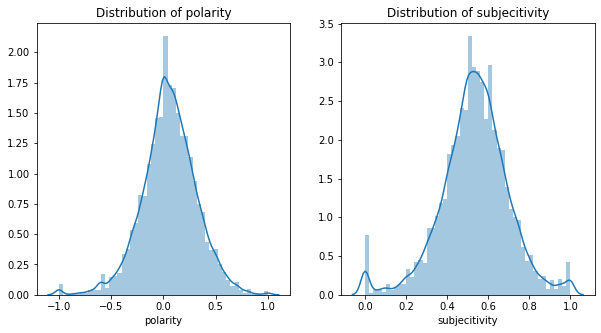

In [262]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,5))
sns.distplot(final_dataset["polarity"], ax = ax1).set(title = "Distribution of polarity")
sns.distplot(final_dataset["subjecitivity"], ax = ax2).set(title = "Distribution of subjecitivity")
plt.show()

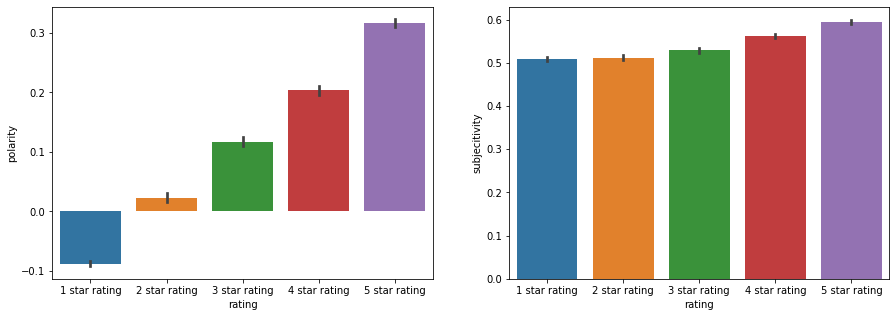

In [267]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))

label_order = ["1 star rating", "2 star rating","3 star rating","4 star rating","5 star rating"]
sns.barplot(data = final_dataset, x = "rating", y = "polarity", order = label_order, ax= ax1)
sns.barplot(data = final_dataset, x = "rating", y = "subjecitivity", order = label_order, ax= ax2)
plt.show()

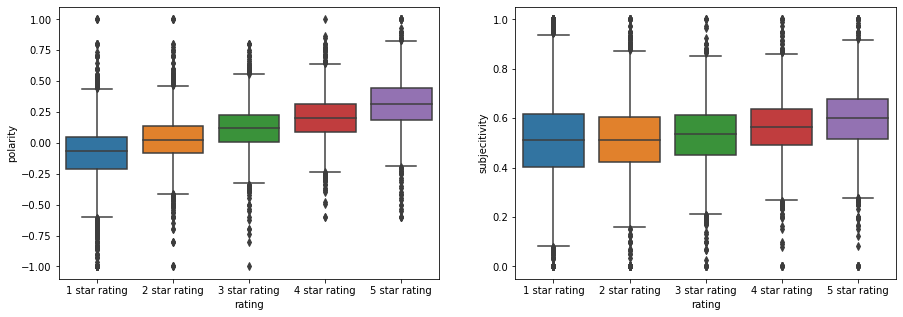

In [271]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))

sns.boxplot(data = final_dataset, x = "rating", y = "polarity", order = label_order, ax = ax1)
sns.boxplot(data = final_dataset, x = "rating", y = "subjecitivity", order = label_order, ax = ax2)
plt.show()

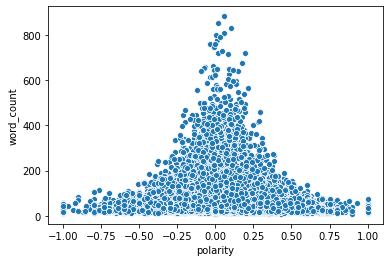

In [272]:
sns.scatterplot(data = final_dataset, x = "polarity", y = "word_count")

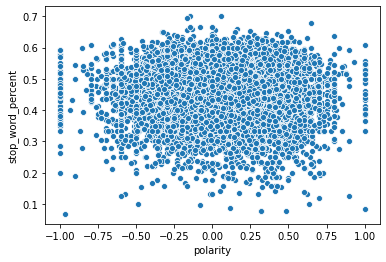

In [274]:
sns.scatterplot(data = final_dataset, x = "polarity", y = "stop_word_percent")

### Tokenize clean_reviews

In [ ]:
# tokenize the data
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer

# tokenize
tokenizer = Tokenizer(num_words = 29656, lower= True)
tokenizer.fit_on_texts(final_dataset["clean_reviews"])
final_dataset["clean_reviews"] = tokenizer.texts_to_sequences(final_dataset["clean_reviews"])

vocab_size = len(tokenizer.word_index)+1
final_dataset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rating,word_count,char_count,average_word_length,stop_word_percent,clean_reviews
0,good,63,334,4.253968,0.444444,"[315, 330, 18, 1219, 468, 570, 2, 133, 3, 90, ..."
1,good,149,770,4.167785,0.463087,"[1731, 64, 97, 430, 2079, 2284, 510, 290, 45, ..."
2,bad,28,151,4.357143,0.285714,"[18, 116, 555, 314, 51, 10, 39, 427, 629, 17, ..."
3,descent,122,628,4.155738,0.483607,"[14, 2, 284, 72, 12, 2, 58, 127, 91, 101, 121,..."
4,good,41,261,5.390244,0.195122,"[219, 122, 6374, 7, 12393, 992, 2805, 94, 212,..."


In [ ]:
final_dataset["clean_reviews"]

### Creating Training and Testing dataset

In [ ]:
# separate train, test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, X_aux_train, X_aux_test, y_train, y_test = train_test_split(final_dataset["clean_reviews"], final_dataset["stop_word_percent"], final_dataset["rating"], test_size = 0.3, random_state = 42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (12334,)
Shape of X_test: (5286,)
Shape of y_train: (12334,)
Shape of y_test: (5286,)


In [ ]:
X_aux_test.shape

(5286,)

### Scale the data and create one-hot-encoding for rating column

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [ ]:
# create padding
from keras_preprocessing.sequence import pad_sequences
maxlen = max(final_dataset["clean_reviews"].apply(lambda x: len(x)))

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)


In [ ]:
from keras.layers import Dense, Dropout, Activation, SimpleRNN, LSTM, Embedding, GRU

In [ ]:
maxlen

423

In [ ]:
# reshape the data
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, SimpleRNN, LSTM
# from keras import optimizers
# from keras.preprocessing.sequence import pad_sequences

# X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1],1))
# X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1],1))
# X_aux_train = np.array(X_aux_train).reshape((X_aux_train.shape[0],1))
# X_aux_test = np.array(X_aux_test).reshape((X_aux_test.shape[0],1))


# print(X_train.shape)
# print(X_test.shape)
# print(X_aux_train.shape)


(12334, 303, 1)
(5286, 303, 1)
(12334, 1)


In [ ]:
# reshape the data
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN, LSTM
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences

X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1]))
X_aux_train = np.array(X_aux_train).reshape((X_aux_train.shape[0]))
X_aux_test = np.array(X_aux_test).reshape((X_aux_test.shape[0]))


print(X_train.shape)
print(X_test.shape)
print(X_aux_train.shape)

(12334, 423)
(5286, 423)
(12334,)


### Fit the RNN model

In [ ]:
num_classes = 3

def rnn_model():
  model = Sequential(name = "RNN_Model")
  model.add(Embedding(tokenizer.num_words, 128, input_shape = [None]))
  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(128, return_sequences=False))
  model.add(Dense(num_classes, activation='softmax', name = "output"))
  model.summary()

  adam = optimizers.Adam(lr = 0.001)
  model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
  return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn = rnn_model, epochs = 20, batch_size = 16)


In [ ]:
model.fit(X_train, y_train_categorical, validation_data = (X_test, y_test_categorical))

Model: "RNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 128)         3795968   
_________________________________________________________________
lstm_23 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               131584    
_________________________________________________________________
output (Dense)               (None, 3)                 387       
Total params: 4,059,523
Trainable params: 4,059,523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
275/771 [=========>....................] - ETA: 7:13 - loss: 1.0725 - accuracy: 0.4489

KeyboardInterrupt: ignored